In [1]:
#Import all the necessary libraries
import vtk
import numpy as np
from vtk.util.numpy_support import vtk_to_numpy
import math
import pyevtk
from matplotlib import pyplot as plt

In [2]:
#Load the dataset
reader = vtk.vtkXMLImageDataReader()
reader.SetFileName("Isabel_Pressure_25.vti")
reader.Update()
imageData = reader.GetOutput() #read data

In [3]:
#Convert the data into numpy array format
temp = vtk_to_numpy(imageData.GetPointData().GetScalars())
dims = imageData.GetDimensions()
dat = temp.reshape(dims[2], dims[1], dims[0])
dat = dat.transpose(2, 1, 0)

dims #dimensions of the data
#dat[249][249][49]

(250, 250, 50)

In [4]:
eta = 0.2 #User-defined sampling fraction/ratio
np.random.seed(0)

In [5]:
#Simple Random Sampling

r = np.random.uniform(0, 1, size = dims[0]*dims[1]*dims[2])
r = r.reshape(dims[0], dims[1], dims[2])

res = np.zeros((dims[0], dims[1], dims[2]))
res.fill(np.nan)

for i in range(dims[0]):
    for j in range(dims[1]):
        for k in range(dims[2]):
            if r[i][j][k] < eta:
                res[i][j][k] = dat[i][j][k]
                
pyevtk.hl.imageToVTK('./srs', cellData = {'pressure': res}) #Create visualization of the modified image

'/Users/palakmishra/Documents/srs.vti'

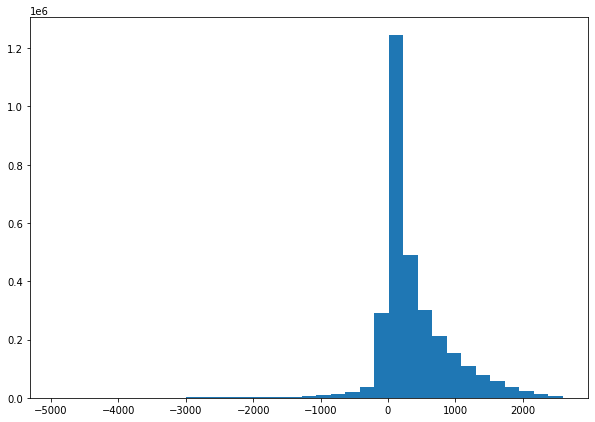

'/Users/palakmishra/Documents/vbis.vti'

In [6]:
#Value-Based Importance Sampling

N = dims[0]*dims[1]*dims[2]
M = eta*N
D = dat.reshape(N)

#User-defined parameter:
B = 35 #Number of bins

#Histogram of the data
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(D, bins = B)
plt.show()

uniqueValues, counts = np.unique(dat, return_counts=True)
sortedBins, _ = np.histogram(uniqueValues, bins=B, weights=counts)
H = sortedBins
dic = dict()
for i in range(B):
    dic[H[i]] = i
dic = dict(sorted(dic.items()))
H = list(dic.keys())

If = np.zeros(B)
C = M/B
temp = B

#Importance sampling algorithm
j = 0
while j < B:
    cj = H[j]
    if cj < C:
        If[j] = cj
        M = M-cj
        temp -= 1
        C = M/temp
        j += 1
    else:
        for k in range(j, B):
            If[k] = C
        break

#Normalization
for j in range(0, B):
    If[j] = If[j]/H[j]
    
i = 0
dic2 = dict()
for j in range(B):
    dic2[sortedBins[j]] = 0
for key in dic:
    dic2[sortedBins[dic[key]]] = If[i]
    i += 1
If = list(dic2.values())

res = np.zeros(dims[0]*dims[1]*dims[2])
res.fill(np.nan)

#Accept-Reject algorithm
rangeOfDat = dat.max()-dat.min()
prop = rangeOfDat/B
for i in range(B):
    idx = np.where(np.logical_and(D >= dat.min() + math.floor(prop)*i, D <= dat.min() + math.floor(prop)*(i+1)))
    r = np.random.uniform(0, 1, size = idx[0].shape)
    for j in range(idx[0].shape[0]):
        if r[j] < If[i]:
            res[idx[0][j]] = D[idx[0][j]]
res = res.reshape((dims[0], dims[1], dims[2]))

pyevtk.hl.imageToVTK('./vbis', cellData = {'pressure': res}) #Create visualization of the modified image